# Chapter 8
## Hopfield networks

    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Blackboard before the deadline (see Blackboard).

Learning goals:
1. Get familiar with energy functions and with updating Hopfield networks by hand
1. Implement a Hopfield network that fulfills a constraint
1. Implement, train and test a Hopfield network on images

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import urllib2
import scipy.misc as sp
import skimage as ski

### Exercise 1: Flip-flop  (2 points)
Consider a Hopfield network consisting of two variables $x_1$ and $x_2$ with thresholds $\theta_1 = 0.5$ and $\theta_2 = 0.5$, and a weight $w_{ij} = -1$. This network implements a so-called flip-flop. 
1. What is the energy function of this network? *(Write down the standard form of $E(\mathbf{x})$, insert the values and simplify it.)*
1. What are the possible energy levels of this network? *(Given the possible state combinations for $x_1$ and $x_2$ in a Hopfield network, which values can $E(\mathbf{x})$ have?)*
1. What are the stable states of this network?

### Solution 1
1. $E(x) = \frac{1}{2}(x_1x_2 - x_1 - x_2)$
1. \begin{array}{ l c r }
      x_1 & x_2 & E(x) \\
      0 & 0 & 0 \\
      0 & 1 & -0.5 \\
      1 & 0 & -0.5 \\
      1 & 1 & -0.5 \\
    \end{array}
1. The stable states are the local minima. If we look at the previous question, these states are: ($x_1=0$ and $x_2=1, x_1=1 $and $x_2=0, x_1=1$ and $x_2=1$)

### Exercise 2: Hopfield net
Consider a Hopfield network with weights
\begin{equation}
\mathbf{W} =
\left[
\begin{array}{llll}
0 & -0.2 & -0.4 & 0\\
-0.2 & 0 & 0.5 & 0.3\\
-0.4 & 0.5 & 0 & 0.8\\
0 & 0.3 & 0.8 & 0
\end{array}
\right]
\end{equation}
and biases
$\boldsymbol{\theta} = (-0.5,-0.3,-0.8,0.2)$.
1. What is the state of the Hopfield network after one sequential update of the first, second, third and fourth node when we start at the initial node state $\mathbf{x} = (0,1,1,1)$? 
1. What do you conclude from your observation?

### Solution 2  (1 point)
1. The state is the same as the initial state
1. We conclude that the initial state is a stable state

### Exercise 3 : A Hopfield network that fulfills a constraint (2 points)

In this exercise you will run a Hopfield model that converges to a state that fulfills a constraint. 

1. Implement a function `optimize(n)` which returns a length `n` vector of node states. The constraint it should solve is that all nodes should be set to `0`, except for a single random node set to `1`.
1. Show that your function works for different values of `n`.

Start from random node states. Choose and implement the necessary weights and biases manually (i.e. you do not train the Hopfield network here). The resulting vector should be the configuration of the network when it has converged to a stable state. Make sure that your implementation fulfills all requirements for Hopfield networks to converge to stable states.

### Solution 3

In [8]:
# The optimization function
def optimize(n):
    node_states = np.random.randint(2, size=n)
    print node_states
    weights = np.full((n,n),-2)
    for i in range(n):
        weights[i,i] = 0
    biases = np.repeat(1,n)
    E = 1
    a = np.zeros(n)
    while E > 0:
        for i in range(n):
            #print weights[i]
            a[i] = np.sum(np.dot(weights[:,i],node_states) + biases[i])
            if a[i] >= 0:
                node_states[i] = 1
            else:
                node_states[i] = 0
        E = -0.5*np.dot(np.dot(node_states.T,weights),node_states) - np.dot(node_states.T, biases)
        #print E, node_states
    return node_states


In [25]:
# Print solutions
print optimize(17)

[0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


### Training a Hopfield network on given patterns

You will now implement a Hopfield network that learns to reconstruct given images. Here you can *a) ignore the bias term*; and *b) use bipolar nodes*. 

The next cells load an image, resize it and store it together with a mirrored version of the same image in the variables `x1` and `x2`, which will be stacked in the training data `X`. These are your *input patterns*. 

In [12]:
# The source image
f = urllib2.urlopen("https://homepages.cae.wisc.edu/~ece533/images/watch.png")

# Read the image
x1 = mpimg.imread(f)

# Make binary
x1 = np.mean(sp.imresize(x1,10),2)
x1[x1 < np.mean(x1.flatten())] = -1 # Black
x1[x1 >= np.mean(x1.flatten())] = 1 # White
x1.astype("int32")

# Make duplicate but mirrored second image
x2 = np.fliplr(x1)

# Flatten images
sz = x1.shape
X = np.stack((x1.flatten(), x2.flatten()), axis=1)

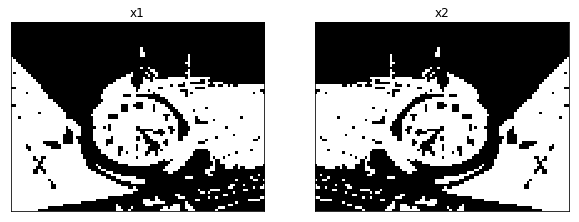

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(X[:, 0].reshape(sz), cmap="gray")
ax[0].set_xticks([], [])
ax[0].set_yticks([], [])
ax[0].set_title("x1")

ax[1].imshow(X[:, 1].reshape(sz), cmap="gray")
ax[1].set_xticks([], [])
ax[1].set_yticks([], [])
ax[1].set_title("x2")

### Exercise 4: Hopfield training  (1 point)
Write a function `hopfield_train(X)` which takes the $n$ *input patterns* `X` (shape $(m,n)$) as argument and returns the weight matrix `w` for a trained Hopfield network with $m$ nodes. Initialize the weights with zeros and then implement the learning rule for the weights. Again, make sure that your network fulfills the requirements for Hopfield network convergence. 

Note that you can write the weight update term per *input pattern* in a single line using the dot product. 

### Solution 4

In [53]:
# Hopfield training
def hopfield_train(X):
    m, n = X.shape
    #print m
    # Initialize weights
    w = np.zeros((m,m))
    #print w       
    # Hebbian learning
    for i in range(m):
        for j in range(m):
        # Avoid self-connections (diagonal)
            if i!=j:
                w[i,j] = w[i,j] + np.dot(X[i,:], X[j,:])    
                #per input pattern??
    return w

### Exercise 5  (1 points)
Write a function `hopfield_test(X, w, n_epochs)` which takes the $n$ initial states `Y` (shape $(m,n)$) and the learned weights `w` and updates all units in random order for `n_epochs` times (i.e., which "runs" your trained Hopfield network for `n_epochs` rounds). The return value should be the updated states `Y` of the Hopfield network. Make sure that your iteration fulfills the requirements for Hopfield network convergence.

### Solution 5

In [43]:
# Hopfield testing
def hopfield_test(X, w, n_epochs=10):
#???????????????????????????????????????????????????????????????????????????? 
    # Loop over epochs
    for e in range(n_epochs):    
        # Loop over examples
        for example in range(X.shape[1]):
            count = 0
            # Loop over nodes
            for node in w[:,example]:
                # Update node
                Y = node + X[count, example]
                count +=1
    return Y

### Exercise 6  (1 points)
Train your hopfield network on the two *input patterns* in `X` and save the weights. 

### Solution 6

In [54]:
# Run hopfield training
weights = hopfield_train(X)
print weights
#so it prints out 2's which is wrong

[[ 0.  2.  2. ...,  0.  0.  0.]
 [ 2.  0.  2. ...,  0.  0.  0.]
 [ 2.  2.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  2.  2.]
 [ 0.  0.  0. ...,  2.  0.  2.]
 [ 0.  0.  0. ...,  2.  2.  0.]]


### Exercise 7 (2 points)

Test whether your trained Hopfield net can reconstruct the original images when starting from different degrees of corruption (which means randomly changing the pattern's node states). Make use of the function `corrupt_images` for this. 

1. Choose 4 degrees of corruption (between min: 10%, max: 100%) you want to test. Corrupt the original input images in `X` accordingly.  
1. Run your trained Hopfield network with the corrupted images as input. It may not need to run for long time. 
1. For both patterns show the original, the corrupted and the reconstructed images next to each other. 
1. For each of the degrees of corruption, comment on what you see. 

In [36]:
def corrupt_images(X, percentage=25):
    Xhat = X.copy()
    n_pixels = int(X.shape[0]*percentage/100)
    for i_example in range(X.shape[1]):
        idx = np.random.permutation(X.shape[0])[:n_pixels]
        Xhat[idx, i_example] = 2 * np.random.randint(0, 2, n_pixels) - 1
    return Xhat

### Solution 7

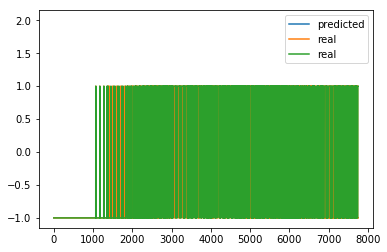

In [41]:
# Corrupt images
X10 = corrupt_images(X, 10)
# Test associative memory properties
pred = hopfield_test(X10, weights)
# Plot results
plt.figure()
plt.plot(pred, label = "predicted")
plt.plot(X, label = "real")
plt.legend()
plt.show() 

Write comments here.

In [ ]:
# Corrupt images

# Test associative memory properties

# Plot results

Write comments here.

In [ ]:
# Corrupt images

# Test associative memory properties

# Plot results

Write comments here.

In [ ]:
# Corrupt images

# Test associative memory properties

# Plot results

Write comments here.